# Necessary Imports

In [1]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
import contractions
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from collections import Counter
import gensim
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
from tensorflow.keras.preprocessing.sequence import pad_sequences
#comment this out if it's already installed
nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mikec\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Loading the dataset

In [2]:
imdb_reviews = pd.read_csv(r"C:\Users\mikec\OneDrive\Data\Advanced Analytics\IMDB Dataset.csv") #path to your local file

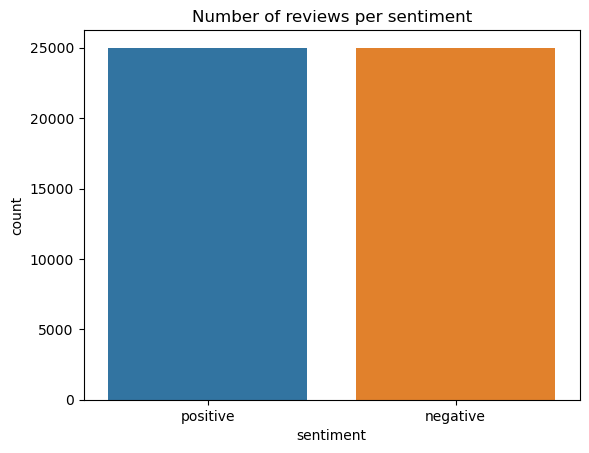

In [3]:
sns.countplot(x=imdb_reviews['sentiment'], data = imdb_reviews)
plt.title("Number of reviews per sentiment")
plt.show()

# **Model 1: TF-IDF features with Naive-Bayes classifier**

## Preprocessing the datata

In [4]:
def data_preprocess_simple(paragraph):
    #remove html tags
    soup = BeautifulSoup(paragraph, "html.parser")
    clean_text = soup.get_text()
    #expands contractions(e.g. it's->it is)
    clean_text = contractions.fix(clean_text)
    #remove punctuation marks
    clean_text = clean_text.translate(str.maketrans(string.punctuation, " " * len(string.punctuation)))
    #convert text to lowercase
    clean_text = clean_text.lower()
    #remove any double whitespaces
    clean_text = re.sub(r'\s+', ' ',clean_text)
    #remove singular characters(not i and a as they can add context)
    clean_text = re.sub(r'(?<!\S)(?!i |a\b).\b(?!\S)', '', clean_text)
    return clean_text

In [5]:
#apply the preprocess to each review 
imdb_reviews['review'] = imdb_reviews['review'].apply(data_preprocess_simple)

C:\Users\mikec\AppData\Local\Temp\ipykernel_14128\192526704.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(paragraph, "html.parser")


In [6]:
#map the labels
imdb_reviews['sentiment'] =  imdb_reviews.sentiment.map({'positive':1, 'negative':0})
imdb_reviews

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production the filming tech...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically there is a family where a little boy...,0
4,petter mattei love in the time of money is a ...,1
...,...,...
49995,i thought this movie did a down right good job...,1
49996,bad plot bad dialogue bad acting idiotic direc...,0
49997,i am a catholic taught in parochial elementary...,0
49998,i am going to have to disagree with the previo...,0


In [7]:
#initialize TfidfVectorizer
vectorizer = TfidfVectorizer()
X = imdb_reviews.review
y = imdb_reviews.sentiment
#calculate the vocabulary of x and convert the text data into a TF-IDF matrix 
data = vectorizer.fit_transform(X)
#print the feature names and the sparse matrix shape
print(vectorizer.get_feature_names_out())
print(f"The shape of tfidf matrix is: {data.shape}")

['00' '000' '00000000000' ... 'żmijewski' 'יגאל' 'כרמון']
The shape of tfidf matrix is: (50000, 103749)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=2)
print("Train: ", y_train.shape)

Train:  (40000,)


## Train the model 

In [9]:
%%time
#fit the data to the model 
clf = MultinomialNB().fit(X_train, y_train)

CPU times: total: 31.2 ms
Wall time: 43.5 ms


## Model accuracy and classification report 

In [10]:
#predict on the unseen data
y_pred = clf.predict(X_test)
#store the metrics
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
#display results 
print("=" * 34)
print(f"Accuracy of the classifier: {accuracy:.3f}")
print("=" * 34 ,"\n")
print("=" * 53)
print("Classification Report:")
print(class_report)
print("=" * 53)

Accuracy of the classifier: 0.864

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      4979
           1       0.88      0.84      0.86      5021

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



## False negative examples 

In [11]:
import numpy as np
#false negatives are predicted as 0, but true label is 1
false_negatives_idx = np.where((y_test == 1) & (y_pred == 0))[0]
#get the corresponding original indices from y_test
false_negative_indices = y_test.index[false_negatives_idx]

#get the original reviews from imdb_reviews using these indices
false_negative_reviews = imdb_reviews.loc[false_negative_indices, 'review']

sample_size = 3
#print some false negative reviews
print(f"Printing {sample_size}/{len(false_negative_reviews)} negative reviews:\n")

for review in false_negative_reviews[:sample_size]: 
    #print the text
    print(review,"\n")   

Printing 3/799 negative reviews:

these are the kinds of movies i loved and still love growing up unlike big budget movies that crate huge plot holes and never acknowledge them this movie takes in all in stride and just makes something you can sit back and enjoy there was some film student earlier that complained it was not a list material but that is not the point the point of this movie is that no everyone likes huge cgi cliché filled movies there are a lot of people who like movies that are meant to just entertain you and not get as much money as they can besides its also nice to know that good old bruce is not dead yet  

well first of all i am a big fanatic of horror movies but however i am pretty sick of all those damn american horror movies they are all about the same thing blood and violence it is not even creepy well it is nothin wrong with the blood and all that does not even bother me but that is not what makes a movie creepy that is why i find this movie entertaining it is 

## Confusion Matrix for the Naive Bayes classifier

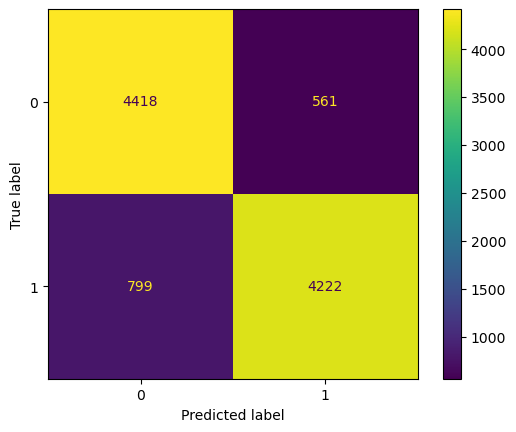

In [12]:
from sklearn.metrics import ConfusionMatrixDisplay
#generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
labels = clf.classes_
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels = labels)
disp.plot()
plt.show()

### Function that prints the prediction based on the custom text given 

In [13]:
def custom_review(text):
    text = data_preprocess_simple(text)
    custom_tfidf = vectorizer.transform([text])  # Vectorize the text
    #use the trained Naive Bayes model to predict sentiment
    prediction = clf.predict(custom_tfidf)
    #print the prediction
    if prediction == 1:
        print("This review is Positive.")
    else:
        print("This review is Negative.")

In [14]:
custom_review("I did not like this movie")

This review is Negative.


# **Model 2: Word2vec with LSTM**

In [15]:
imdb_reviews = pd.read_csv(r"C:\Users\mikec\OneDrive\Data\Advanced Analytics\IMDB Dataset.csv")

### Preprocess text and return tokens after removing most stopwords

In [16]:
def data_preprocess(paragraph):
    #remove html tags
    soup = BeautifulSoup(paragraph, "html.parser")
    clean_text = soup.get_text()
    #expands contractions(e.g. it's->it is)
    clean_text = contractions.fix(clean_text)
    #remove punctuation marks
    clean_text = clean_text.translate(str.maketrans(string.punctuation, " " * len(string.punctuation)))
    #convert text to lowercase
    clean_text = clean_text.lower()
    #remove any double whitespaces
    clean_text = re.sub(r'\s+', ' ',clean_text)
    #remove singular characters(not i and a as they can add context)
    clean_text = re.sub(r'(?<!\S)(?!i |a\b).\b(?!\S)', '', clean_text)
     #tokenize the text
    tokens = word_tokenize(clean_text)
    #remove stopwords (except some we consider important )
    important_words = {'no', 'not', 'nor'}
    stop_words = set(stopwords.words('english')) - important_words
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

In [17]:
imdb_reviews['tokens'] = imdb_reviews["review"].apply(data_preprocess)

C:\Users\mikec\AppData\Local\Temp\ipykernel_14128\3334120628.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(paragraph, "html.parser")


In [18]:
imdb_reviews["tokens"][0]

['one',
 'reviewers',
 'mentioned',
 'watching',
 'oz',
 'episode',
 'hooked',
 'right',
 'exactly',
 'happened',
 'first',
 'thing',
 'struck',
 'oz',
 'brutality',
 'unflinching',
 'scenes',
 'violence',
 'set',
 'right',
 'word',
 'go',
 'trust',
 'not',
 'show',
 'faint',
 'hearted',
 'timid',
 'show',
 'pulls',
 'no',
 'punches',
 'regards',
 'drugs',
 'sex',
 'violence',
 'hardcore',
 'classic',
 'use',
 'word',
 'called',
 'oz',
 'nickname',
 'given',
 'oswald',
 'maximum',
 'security',
 'state',
 'penitentary',
 'focuses',
 'mainly',
 'emerald',
 'city',
 'experimental',
 'section',
 'prison',
 'cells',
 'glass',
 'fronts',
 'face',
 'inwards',
 'privacy',
 'not',
 'high',
 'agenda',
 'city',
 'home',
 'many',
 'aryans',
 'muslims',
 'gangstas',
 'latinos',
 'christians',
 'italians',
 'irish',
 'scuffles',
 'death',
 'stares',
 'dodgy',
 'dealings',
 'shady',
 'agreements',
 'never',
 'far',
 'away',
 'would',
 'say',
 'main',
 'appeal',
 'show',
 'due',
 'fact',
 'goes',
 'sh

In [19]:
#training the word2vec model
model = Word2Vec(sentences=imdb_reviews["tokens"], vector_size=100, window=2, min_count=4, workers=4)
#save the model to use later
model.save("word2vec_imdb.model")

In [20]:
vector = model.wv["movie"]  # Get the 100-dimensional vector for "movie"
similar_words = model.wv.most_similar("movie")  # Find words similar to "movie"

In [21]:
#Load the trained model
model = Word2Vec.load("word2vec_imdb.model")
#print 5 most similar words
similar_words = model.wv.most_similar("film", topn=5)
print(f"Words similar to 'film': {similar_words}")

Words similar to 'film': [('movie', 0.9035243988037109), ('flick', 0.6812941431999207), ('documentary', 0.6486550569534302), ('films', 0.6484357714653015), ('cinema', 0.6167618632316589)]


### Store the pre-learned embeddings in a matrix

In [22]:
#create word-index dictionary
word_index = {word: i + 1 for i, word in enumerate(model.wv.index_to_key)}

#create embedding matrix
embedding_dim = 100
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    embedding_matrix[i] = model.wv[word]

### Convert reviews into sequences(list of integers corresponding to words)

In [23]:
#convert reviews into sequences
sequences = [[word_index[word] for word in tokens if word in word_index] for tokens in imdb_reviews["tokens"]]

#pad sequences to same length
max_length = 100  
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding="post")

#Convert labels to binary (1 = positive, 0 = negative)
y = imdb_reviews["sentiment"].map({"positive": 1, "negative": 0}).values

### Represent each word by the average vector and each review by a singular vector of 100 features

In [24]:
# Function to get the average word vector for a review
def get_average_word2vec(tokens, model, vector_size):
    #fetch the word vector from the model
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    #calculate the average vector
    if len(vectors) > 0:
        return np.mean(vectors, axis=0) 
    else:
        return np.zeros(vector_size)

#convert all reviews to vectors
imdb_reviews["word2vec_features"] = imdb_reviews["tokens"].apply(lambda x: get_average_word2vec(x, model, 100))

#convert to numpy array
X = np.vstack(imdb_reviews["word2vec_features"].values)
y = imdb_reviews["sentiment"].map({"positive": 1, "negative": 0}).values 

In [25]:
imdb_reviews["word2vec_features"]

0        [-0.16971695, 0.088050395, -0.11366219, -0.098...
1        [-0.043937497, 0.2622934, -0.10029888, 0.17887...
2        [-0.09349208, 0.26660964, -0.22031964, -0.0090...
3        [-0.019486068, 0.24173062, 0.07851321, -0.0910...
4        [-0.30187118, 0.20971435, 0.08313339, 0.101777...
                               ...                        
49995    [-0.08676772, 0.26421085, -0.0559375, 0.036651...
49996    [-0.011401908, 0.16347972, 0.09641886, 0.14967...
49997    [-0.13864885, 0.038528465, 0.015638143, -0.243...
49998    [-0.16333187, 0.1355747, 0.098055854, 0.004770...
49999    [-0.21529555, 0.2777782, 0.11501959, 0.1807905...
Name: word2vec_features, Length: 50000, dtype: object

## Train_Test split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y, test_size=0.2, random_state=42)

## Create the RNN 

In [27]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
voc_size=63015
model = Sequential()

#define the Embedding layer
model.add(Embedding(input_dim=44073 , 
                    output_dim=100,         
                    input_length=100, 
                    weights=[embedding_matrix],
                    trainable=False))       

#add the rest of the layers 
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(32, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

#compile the model
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model.build((None, 100))
#Print model summary
model.summary()

C:\Users\mikec\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 100)            │       4,407,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 100, 128)            │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,576,069 (17.46 MB)

 Trainable params: 168,769 (659.25 KB)

 Non-trainable params: 4,407,300 (16.81 MB)

## Train the neural network and plot the epoch-validation accuracy plot

Epoch 1/4
625/625 ━━━━━━━━━━━━━━━━━━━━ 53s 80ms/step - accuracy: 0.7860 - loss: 0.4642 - val_accuracy: 0.8392 - val_loss: 0.4006
Epoch 2/4
625/625 ━━━━━━━━━━━━━━━━━━━━ 51s 82ms/step - accuracy: 0.7820 - loss: 0.4525 - val_accuracy: 0.8655 - val_loss: 0.3216
Epoch 3/4
625/625 ━━━━━━━━━━━━━━━━━━━━ 52s 83ms/step - accuracy: 0.8652 - loss: 0.3177 - val_accuracy: 0.8702 - val_loss: 0.2979
Epoch 4/4
625/625 ━━━━━━━━━━━━━━━━━━━━ 52s 84ms/step - accuracy: 0.8788 - loss: 0.2915 - val_accuracy: 0.8812 - val_loss: 0.2831


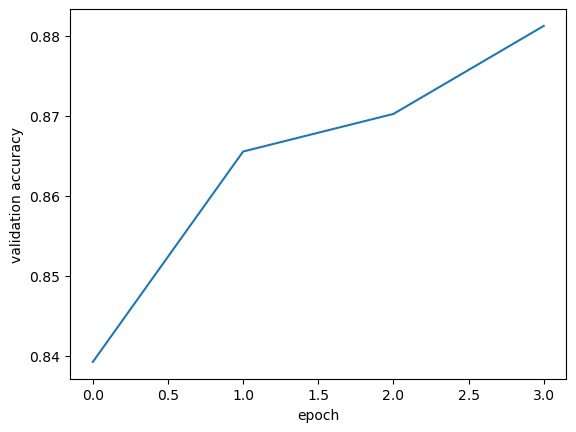

CPU times: total: 1min 13s
Wall time: 3min 29s


In [28]:
%%time
import keras
import matplotlib.pyplot as plt
history = model.fit(X_train, y_train, epochs=4, batch_size=64, validation_data=(X_test, y_test))
plt.plot(history.history['val_accuracy'])
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.show()

In [29]:
y_pred = model.predict(X_test)
y

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step


array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [30]:
y_pred_binary = (y_pred >= 0.5).astype(int)

In [31]:
accuracy = accuracy_score(y_test, y_pred_binary)
class_report = classification_report(y_test, y_pred_binary)
print("Classification Report:\n",class_report)

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.86      0.88      4961
           1       0.87      0.90      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



### Generate the confusion matrix

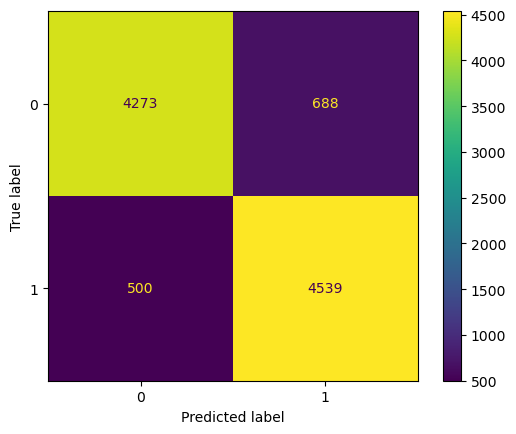

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay
#generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
plt.show()

In [33]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
import gradio as gr
max_length=100
def custom_text_review(text):
    #preprocess
    tokens = data_preprocess(text)  # Use the function you defined earlier
    if not tokens:  
        return "Neutral", 0.5 
    
    sequence = [[word_index[word] for word in tokens if word in word_index]]
    
    #pad sequence
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding="post")
    
    #get prediction
    prediction = model.predict(padded_sequence)[0][0]  # Extract single value

    #convert probability to label & confidence
    sentiment_label = "Positive" if prediction >= 0.5 else "Negative"
    confidence = max(prediction, 1 - prediction) 

    return sentiment_label, confidence

#launch simple web interface
demo = gr.Interface(fn=custom_text_review, inputs=gr.Textbox(placeholder="Review"), outputs="text", title="Sentiment Analysis")
demo.launch()


* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
